In [1]:
import os
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync/')


In [2]:
# vehicle assignment function
def veh_type_simulator(n_truck, vehicle_type_fraction): # Simulate mode choice
    choice = np.random.multinomial(n_truck, vehicle_type_fraction, size = 1)
    choice = pd.Series(choice[0])
#     print(choice)
    return(choice)

def split_dataframe(df, chunk_size = 100000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [3]:
scenario_name = 'TDA_low'
analysis_year = '2050'
firms = read_csv('outputs_aus_fleet/'+ analysis_year + '/forecast_firms_with_fleet_' + scenario_name + '.csv')
private_fleet = read_csv('inputs/fleet/TX_private_fleet_size_distribution_V2.csv')
for_hire_fleet = read_csv('inputs/fleet/TX_for_hire_fleet_size_distribution_V2.csv')
for_lease_fleet = read_csv('inputs/fleet/TX_for_lease_fleet_size_distribution_V2.csv')
cargo_type_distribution = read_csv("inputs/fleet/probability_of_cargo_group.csv")

# forecast values
national_fleet_composition = read_csv('inputs/fleet/' + scenario_name + '/TDA_vehicle_stock.csv')
vehicle_type_by_state = read_csv('inputs/fleet/' + scenario_name + '/fleet_composition_by_state.csv')
ev_fraction = read_csv('inputs/fleet/' + scenario_name + '/EV_fraction_by_type.csv')

state_fips_lookup = read_csv('inputs/us-state-ansi-fips.csv')
# vehicle_type_fraction = [0.206287,	0.505178, 0.244464, 0.044071]  # will be replaced once input from Alicia is ready

In [4]:
# filter vehicle composition data

vehicle_type_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Year'] == int(analysis_year)]

national_fleet_composition = \
national_fleet_composition.loc[national_fleet_composition['Year'] == int(analysis_year)]

ev_fraction = ev_fraction.loc[ev_fraction['Year'] == int(analysis_year)]

vehicle_type_by_state.head(5)

,Year,state,Service type,vehicle type,fuel type,vehicle category,veh_fraction
96,2050,ALABAMA,FOR HIRE,Class 4-6 Vocational,Diesel,Diesel Class 4-6 Vocational,5.490349e-02
97,2050,ALABAMA,FOR HIRE,Class 4-6 Vocational,Electric,Electric Class 4-6 Vocational,9.559017e-03
98,2050,ALABAMA,FOR HIRE,Class 4-6 Vocational,Gasoline,Gasoline Class 4-6 Vocational,3.059405e-02
163,2050,ALABAMA,FOR HIRE,Class 7&8 Tractor,Diesel,Diesel Class 7&8 Tractor,8.076626e-01
164,2050,ALABAMA,FOR HIRE,Class 7&8 Tractor,Electric,Electric Class 7&8 Tractor,4.038992e-07


In [5]:
# load b2b output
combined_b2b_flow = None
for i in range(5):
    sctg = i + 1
    sctg_code = 'sctg' + str(sctg)
    file_dir = 'mode_choice/outputs/' + sctg_code + '_truck/'
    filelist = [file for file in os.listdir(file_dir) if (file.endswith('.csv'))]
    print(sctg_code)
    combined_csv = pd.concat([read_csv(file_dir + f, low_memory=False) for f in filelist ])
    combined_csv = combined_csv.loc[combined_csv['mode_choice'] == 'Private Truck']
    combined_b2b_flow = pd.concat([combined_b2b_flow, combined_csv])
#     break
combined_b2b_flow.head(5)

sctg1
sctg2
sctg3
sctg4
sctg5


,BuyerID,BuyerZone,BuyerNAICS,SellerID,SellerZone,SellerNAICS,TruckLoad,SCTG_Group,shipment_id,orig_FAFID,dest_FAFID,mode_choice,probability,Distance,Travel_time
0,366325,4424,230301,122652,2245,212310.0,35.535873,1,7000001,488,488,Private Truck,0.408465,0.0,4.0
1,366325,4424,230301,122652,2245,212310.0,35.535873,1,7000003,488,488,Private Truck,0.408465,0.0,4.0
2,366325,4424,230301,122652,2245,212310.0,35.535873,1,7000004,488,488,Private Truck,0.408465,0.0,4.0
3,366325,4424,230301,122652,2245,212310.0,35.535873,1,7000005,488,488,Private Truck,0.408465,0.0,4.0
5,366325,4424,230301,122652,2245,212310.0,35.535873,1,7000008,488,488,Private Truck,0.408465,0.0,4.0


<AxesSubplot:>

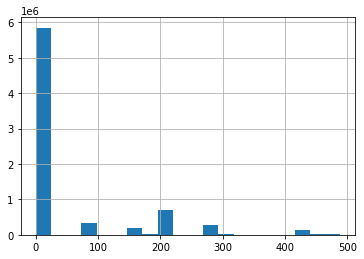

In [6]:
combined_b2b_flow.Distance.hist(bins = 20)

In [6]:
# select firms with private truck shipment
selected_firms_with_load = combined_b2b_flow.groupby(['SellerID'])[['TruckLoad']].sum()
selected_firms_with_load = selected_firms_with_load.reset_index()
selected_firms_with_load.columns = ['BusID', 'Production']
print(len(selected_firms_with_load))
selected_firms_with_load.head(5)

10847


,BusID,Production
0,1017,116441.482874
1,1079,49740.106750
2,1154,12078.250752
3,1156,4793.672234
4,1157,65034.197466


In [7]:
# separate firms with/without private truck shipment
print(len(firms))
selected_sellers = selected_firms_with_load.BusID.unique()
firms_without_adj = firms.loc[~firms['BusID'].isin(selected_sellers)]
firms_with_adj = pd.merge(firms, selected_firms_with_load,
                          on = 'BusID', how = 'inner')
print(len(firms_without_adj))
print(len(firms_with_adj))
firms_with_adj.head(5)

8219823
8208976
10847


,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,EV_powertrain (if any),Production
0,459,1,48061,489,114000,5,0.914722,100239,2068,25.879346,...,TEXAS,0,0,0,0,0,0,0,Battery Electric,53.042500
1,461,1,48061,489,114000,5,0.914722,100241,1960,26.068389,...,TEXAS,0,0,0,0,0,0,0,Battery Electric,3103.745944
2,462,1,48061,489,114000,5,0.914722,100242,1914,26.139325,...,TEXAS,0,0,0,0,0,0,0,Battery Electric,1476.297143
3,463,1,48061,489,114000,5,0.914722,100243,1942,26.182448,...,TEXAS,0,0,0,0,0,0,0,Battery Electric,947.493041
4,464,1,48061,489,114000,5,0.914722,100244,2067,25.856533,...,TEXAS,0,0,0,0,0,0,0,Battery Electric,1486.334865


In [8]:
# format fleet composition
list_of_veh_tech = vehicle_type_by_state['vehicle category'].unique().tolist()

private_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'PRIVATE']
private_fleet_by_state_wide = pd.pivot_table(private_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
private_fleet_by_state_wide = private_fleet_by_state_wide.reset_index()


for_hire_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'FOR HIRE']
for_hire_fleet_by_state_wide = pd.pivot_table(for_hire_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_hire_fleet_by_state_wide = for_hire_fleet_by_state_wide.reset_index()


for_lease_fleet_by_state = \
vehicle_type_by_state.loc[vehicle_type_by_state['Service type'] == 'LEASE']
for_lease_fleet_by_state_wide = pd.pivot_table(for_lease_fleet_by_state,
                                             values='veh_fraction', 
                                             index=['state'],
                                             columns=['vehicle category'], 
                                             aggfunc=np.mean, fill_value=0)
for_lease_fleet_by_state_wide = for_lease_fleet_by_state_wide.reset_index()

private_fleet_by_state_wide.head(5)

vehicle category,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,ALABAMA,0.238441,0.303801,0.253754,0.041514,1.519261e-07,0.029074,0.132867
1,ALASKA,0.270126,0.221711,0.278002,0.047030,1.108742e-07,0.031852,0.150523
2,ARIZONA,0.269282,0.308357,0.201570,0.046884,1.542042e-07,0.023095,0.150053
3,ARKANSAS,0.155329,0.538998,0.171800,0.027044,2.695442e-07,0.019684,0.086555
4,CALIFORNIA,0.273867,0.327610,0.177406,0.047682,1.638327e-07,0.020326,0.152608


In [9]:
print(firms_with_adj.columns)
firms_with_adj = firms_with_adj[['Unnamed: 0', 'esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'Production']]

Index(['Unnamed: 0', 'esizecat', 'CBPZONE', 'FAFZONE', 'Industry_NAICS6_Make',
       'Commodity_SCTG', 'Emp', 'BusID', 'MESOZONE', 'lat', 'lon', 'n_trucks',
       'st', 'stname', 'stusps', 'state', 'Diesel Class 4-6 Vocational',
       'Diesel Class 7&8 Tractor', 'Diesel Class 7&8 Vocational',
       'Electric Class 4-6 Vocational', 'Electric Class 7&8 Tractor',
       'Electric Class 7&8 Vocational', 'Gasoline Class 4-6 Vocational',
       'EV_powertrain (if any)', 'Production'],
      dtype='object')


10847


,fleet_size,min_size,fraction_of_carrier,avg_truck_per_carrier,total_truck_std,n_trucks
0,0-2,0,0.709745,1.218434,0.413643,1
0,0-2,0,0.709745,1.218434,0.413643,1
0,0-2,0,0.709745,1.218434,0.413643,2
0,0-2,0,0.709745,1.218434,0.413643,1
0,0-2,0,0.709745,1.218434,0.413643,1


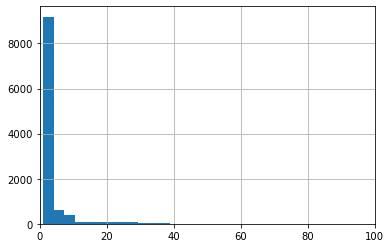

In [10]:
# re-generate fleet size for selected firms
sample_size = len(firms_with_adj)
# print(tx_private_fleet.columns)
private_fleet_short = private_fleet[['fleet_size', 'min_size', 
                                    'fraction_of_carrier', 
                                    'avg_truck_per_carrier', 
                                    'total_truck_std']]

firm_fleet_sample = \
private_fleet_short.sample(n = sample_size,
                           weights = private_fleet_short['fraction_of_carrier'],
                           replace = True)
print(len(firm_fleet_sample))
# generate random fleet size
firm_fleet_sample.loc[:, 'n_trucks'] = np.random.normal(loc = firm_fleet_sample.loc[:, 'avg_truck_per_carrier'],
                                                   scale = firm_fleet_sample.loc[:, 'total_truck_std'])
criteria = (firm_fleet_sample['n_trucks'] <= 1)
firm_fleet_sample.loc[criteria, 'n_trucks'] = 1
firm_fleet_sample.loc[:, 'n_trucks'] = np.round(firm_fleet_sample.loc[:, 'n_trucks'], 0)
firm_fleet_sample.loc[:, 'n_trucks'] = firm_fleet_sample.loc[:, 'n_trucks'].astype(int)

firm_fleet_sample['n_trucks'].hist(bins = 1000)
plt.xlim([0,100])
firm_fleet_sample.head(5)

In [11]:
# append vehicle composition to firms by state
firm_fleet_sample = firm_fleet_sample.sort_values(by = ['n_trucks'], ascending = True)
firms_with_adj = firms_with_adj.sort_values(by = ['Production'], ascending = True)

firm_fleet_sample_short = firm_fleet_sample[['n_trucks']]

firms_with_fleet = pd.concat([firms_with_adj.reset_index(drop=True), 
                              firm_fleet_sample_short.reset_index(drop=True)], axis=1)

firms_with_fleet.loc[:, 'FAFZONE'] = firms_with_fleet.loc[:,'FAFZONE'].astype(str).str.zfill(3)
firms_with_fleet.loc[:, 'st'] = firms_with_fleet.loc[:, 'FAFZONE'].str[:2]
firms_with_fleet.loc[:, 'st'] = firms_with_fleet.loc[:, 'st'].astype(int)

firms_with_fleet = pd.merge(firms_with_fleet, state_fips_lookup,
                            on = 'st', how = 'left')

firms_with_fleet.loc[:,'stname'] = firms_with_fleet.loc[:,'stname'].str.upper()

firms_with_fleet = pd.merge(firms_with_fleet, private_fleet_by_state_wide,
                            left_on = 'stname', right_on = 'state', how = 'left')

firms_with_fleet.head(5)

,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,2046424,1,48241,489,424400,7,3.257909,1424234,3691,30.491008,...,TEXAS,TX,TEXAS,0.187755,0.482842,0.172172,0.032689,2.414617e-07,0.019727,0.104623
1,4423872,1,48375,489,424700,17,4.165485,1472198,4797,35.209374,...,TEXAS,TX,TEXAS,0.187755,0.482842,0.172172,0.032689,2.414617e-07,0.019727,0.104623
2,5333443,1,48029,488,423100,36,4.608807,1158435,721,29.486219,...,TEXAS,TX,TEXAS,0.187755,0.482842,0.172172,0.032689,2.414617e-07,0.019727,0.104623
3,710425,1,48183,489,425000,0,2.561992,1508346,2896,32.377818,...,TEXAS,TX,TEXAS,0.187755,0.482842,0.172172,0.032689,2.414617e-07,0.019727,0.104623
4,5612744,1,48029,488,423100,36,4.842066,1168231,1442,29.565820,...,TEXAS,TX,TEXAS,0.187755,0.482842,0.172172,0.032689,2.414617e-07,0.019727,0.104623


In [12]:
# assign vehicle technology
chunks = split_dataframe(firms_with_fleet)
i = 0
for chunk in chunks:
    print('processing chunk ' + str(i))
    chunk[list_of_veh_tech] = \
    chunk.apply(
            lambda row: veh_type_simulator(row['n_trucks'], row[list_of_veh_tech]), axis=1, result_type ='expand')
    # print(np.random.multinomial(testing_fleet_sample['n_trucks'], vehicle_type_fraction))
    if i==0:
        firms_with_fleet = chunk
    else:
        firms_with_fleet = pd.concat([firms_with_fleet, chunk])
    i += 1
firms_with_fleet.head(5)

processing chunk 0


,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,stname,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational
0,2046424,1,48241,489,424400,7,3.257909,1424234,3691,30.491008,...,TEXAS,TX,TEXAS,0,1,0,0,0,0,0
1,4423872,1,48375,489,424700,17,4.165485,1472198,4797,35.209374,...,TEXAS,TX,TEXAS,0,0,1,0,0,0,0
2,5333443,1,48029,488,423100,36,4.608807,1158435,721,29.486219,...,TEXAS,TX,TEXAS,0,1,0,0,0,0,0
3,710425,1,48183,489,425000,0,2.561992,1508346,2896,32.377818,...,TEXAS,TX,TEXAS,0,1,0,0,0,0,0
4,5612744,1,48029,488,423100,36,4.842066,1168231,1442,29.565820,...,TEXAS,TX,TEXAS,0,1,0,0,0,0,0


In [13]:
# assign EV type
# print(ev_fraction)

# carriers_with_fleet.loc[:, 'n_trucks'] = carriers_with_fleet.loc[:, list_of_veh_tech].sum(axis = 1)
# leasing_with_fleet.loc[:, 'n_trucks'] = leasing_with_fleet.loc[:, list_of_veh_tech].sum(axis = 1)

powertrain = ev_fraction.Powertrain.to_numpy()
print(powertrain)
probability = ev_fraction.EV_fraction.to_numpy()

sample_size = len(firms_with_fleet)
firms_with_fleet.loc[:, 'EV_powertrain (if any)'] = \
pd.Series(np.random.choice(powertrain, size = sample_size, p=probability) ) 

firms_with_fleet.head(5)

['Battery Electric' 'H2 Fuel Cell' 'PHEV Diesel' 'PHEV Gasoline']


,Unnamed: 0,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,...,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,EV_powertrain (if any)
0,2046424,1,48241,489,424400,7,3.257909,1424234,3691,30.491008,...,TX,TEXAS,0,1,0,0,0,0,0,Battery Electric
1,4423872,1,48375,489,424700,17,4.165485,1472198,4797,35.209374,...,TX,TEXAS,0,0,1,0,0,0,0,Battery Electric
2,5333443,1,48029,488,423100,36,4.608807,1158435,721,29.486219,...,TX,TEXAS,0,1,0,0,0,0,0,Battery Electric
3,710425,1,48183,489,425000,0,2.561992,1508346,2896,32.377818,...,TX,TEXAS,0,1,0,0,0,0,0,Battery Electric
4,5612744,1,48029,488,423100,36,4.842066,1168231,1442,29.565820,...,TX,TEXAS,0,1,0,0,0,0,0,Battery Electric


In [14]:
firms_with_fleet.loc[firms_with_fleet['EV_powertrain (if any)'].isin(['PHEV Diesel', 'PHEV Gasoline']), 'EV_powertrain (if any)'] = 'PHEV'

In [15]:
firms_with_fleet = firms_with_fleet.drop(columns=['Unnamed: 0', 'Production'])
firms_without_adj = firms_without_adj.drop(columns=['Unnamed: 0'])
firms_output = pd.concat([firms_without_adj, firms_with_fleet])
print(len(firms_output))
firms_output.head(5)

8219823


,esizecat,CBPZONE,FAFZONE,Industry_NAICS6_Make,Commodity_SCTG,Emp,BusID,MESOZONE,lat,lon,...,stusps,state,Diesel Class 4-6 Vocational,Diesel Class 7&8 Tractor,Diesel Class 7&8 Vocational,Electric Class 4-6 Vocational,Electric Class 7&8 Tractor,Electric Class 7&8 Vocational,Gasoline Class 4-6 Vocational,EV_powertrain (if any)
0,1,89,393,52A000,0,0.555556,3144893,20089,39.822301,-82.765731,...,OH,OHIO,0,0,0,0,0,0,0,Battery Electric
1,1,123,531,52A000,0,0.555556,3144876,20123,46.839551,-122.659364,...,WA,WASHINGTON,0,0,0,0,0,0,0,Battery Electric
2,1,123,531,52A000,0,0.555556,3144877,20123,47.948497,-121.199226,...,WA,WASHINGTON,0,0,0,0,0,0,0,Battery Electric
3,1,112,484,52A000,0,0.555556,3144878,20112,33.273253,-96.930952,...,TX,TEXAS,0,0,0,0,0,0,0,Battery Electric
4,1,112,484,52A000,0,0.555556,3144879,20112,32.557108,-96.436672,...,TX,TEXAS,0,0,0,0,0,0,0,Battery Electric


In [16]:
# writing output
firms_output.to_csv('outputs_aus_fleet/' + analysis_year + '/synthetic_firms_with_fleet_'+ scenario_name + '_mc_adjusted.csv')